<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


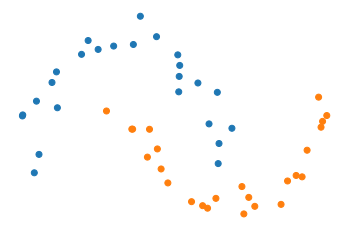

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

# Set random seeds
np.random.seed(42)

# number of samples
N=50

# Let's use the Moons dataset
X, Y = make_moons(n_samples=N, noise=0.1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in Y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# data re-uploading classifier circuit
def circuit(params,x):
    L1 = int(params.size/3)
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    for k in range(L1):
        qc.u(x[0],x[1],0.0,qr[0])
        qc.u(params[3*k+0], params[3*k+1], params[3*k+2], qr[0]) # su(2) rotation
    qc.measure(qr, cr[0])
    return qc

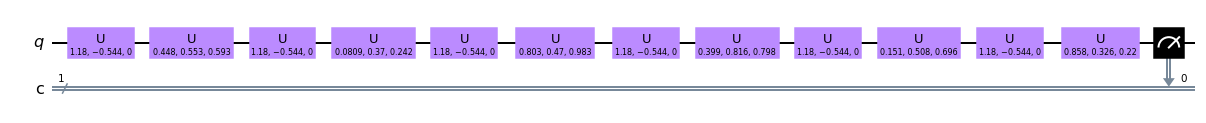

In [3]:
L = 6 # number of layers 

params = np.random.rand(L*3)

qc = circuit(params, X[1])
qc.draw('mpl')

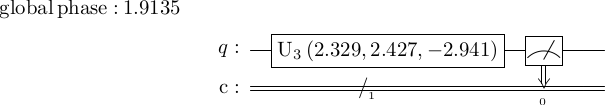

In [4]:
from qiskit import Aer, transpile, assemble
# try different simulators 
# https://qiskit.org/documentation/tutorials/simulators/1_aer_provider.html
backend = Aer.get_backend("aer_simulator_statevector") #'statevector' qasm_simulator
NUM_SHOTS = 1000

t_qc = transpile(qc, backend)
t_qc.draw('latex') #mpl

In [5]:
# predict
def fidelity(params,x,y):
    # Obtain a quantum circuit instance from the paramters
    qc = circuit(params,x)
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    t_qc = transpile(qc, backend) # to convert 3 angles to 1
    result = backend.run(t_qc,shots=NUM_SHOTS).result()
    # Obtain the counts for each measured state 
    d = result.get_counts(qc)
    # return the predicted probability to observe outcome y
    if str(y) in d:
        return d[str(y)]/NUM_SHOTS
    else:
        return 0

# infidelity loss
def loss(params,x,y):
    return 1-fidelity(params,x,y)

# average loss over the data
def averageloss(params): 
    return sum(loss(params,X[k],Y[k]) for k in range(N))/N

# predict the output from the maximum fidelity
def predict(params,x):
    if loss(params,x,0) < 0.5:
        return 0
    else:
        return 1
    

In [6]:
loss(params,X[11],Y[11])

0.137

In [7]:
averageloss(params)

0.40893999999999997

In [8]:
from scipy.optimize import minimize
from scipy.spatial.distance import hamming

res = minimize(averageloss,params,method='COBYLA')
res.fun

0.14073999999999998

In [9]:
Nt = 200
# generate a testing set 
Xt, Yt = make_moons(n_samples=Nt, noise=0.1)

# check the classifier's prediction
Ypred = [predict(res.x,Xt[k]) for k in range(Nt)]

# calculate the distance between Yt and Ypred, 
# i.e. the percentage of wrongly classified data
hamming(Yt,Ypred)*100

5.5

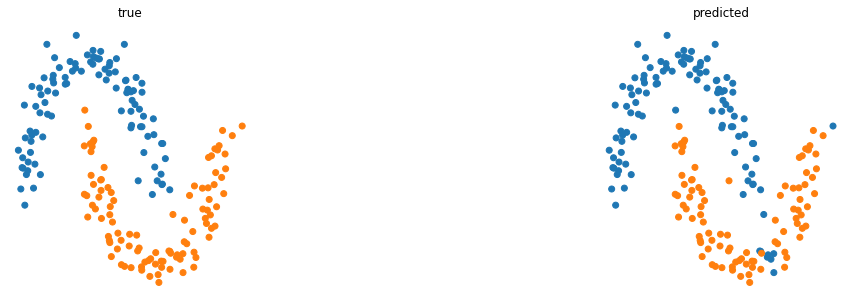

In [10]:
c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in Yt]  # colours for each class
cpred = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in Ypred]  # colours for each class
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("true")
plt.scatter(Xt[:, 0], Xt[:, 1], c=c)
plt.subplot(1,3,3)
plt.axis("off")
plt.title("predicted")
plt.scatter(Xt[:, 0], Xt[:, 1], c=cpred)
plt.show()

# Run predictions on real hardware

In [13]:
from qiskit import IBMQ

# set up the account first using my guide
IBMQ.load_account()

# provider = IBMQ.get_provider('ibm-q-education')
provider = IBMQ.get_provider('ibm-q')

# see https://quantum-computing.ibm.com/services?services=systems 
#for a list of backends... we use armonk as we need a single qubit
backend = provider.get_backend('ibmq_armonk')

ibmqfactory.load_account:WARNING:2023-02-02 15:31:51,070: Credentials are already in use. The existing account in the session will be replaced.


Traceback (most recent call last):
  Input In [13] in <cell line: 11>
    backend = provider.get_backend('ibmq_armonk')
  File /opt/conda/lib/python3.8/site-packages/qiskit/providers/provider.py:55 in get_backend
    raise QiskitBackendNotFoundError("No backend matches the criteria")
QiskitBackendNotFoundError: 'No backend matches the criteria'

Use %tb to get the full traceback.


In [ ]:
predict(res.x,Xt[1])

In [ ]:
# check the classifier's prediction
Ypred = [predict(res.x,Xt[k]) for k in range(Nt)]

# calculate the distance between Yt and Ypred, 
# i.e. the percentage of wrongly classified data
hamming(Yt,Ypred)*100

In [ ]:
c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in Yt]  # colours for each class
cpred = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in Ypred]  # colours for each class
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("true")
plt.scatter(Xt[:, 0], Xt[:, 1], c=c)
plt.subplot(1,3,3)
plt.axis("off")
plt.title("predicted")
plt.scatter(Xt[:, 0], Xt[:, 1], c=cpred)
plt.show()

## Congrats for the first QML prediction on quantum hardware!